In [1]:
import tensorflow as tf
import os
import sys
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
import time
import tensorflow_hub as hub
#from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


resizing training images and masks


100%|██████████| 379/379 [02:28<00:00,  2.55it/s]


Done!


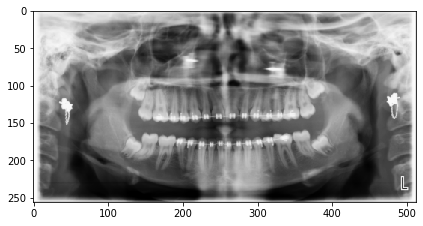

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


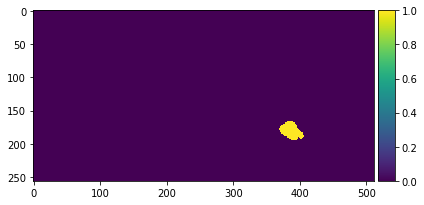

In [59]:
#pre-processing and check all images and masks correctly read
IMG_WIDTH = 512
IMG_HEIGHT = 256
IMG_CHANNELS = 1
 
DATA_PATH = '/content/drive/MyDrive/Colab_Notebooks/GP/dataset/training_set/images/' # Training original images
Mask_path1= '/content/drive/MyDrive/Colab_Notebooks/GP/dataset/training_set/segmentation_map/'   # Segmentation Map
#Mask_path2= ''

seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[2]

len(image_ids)
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('resizing training images and masks')
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  try:
    path = DATA_PATH 
    img = imread(path+ id_)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(Mask_path1))[2]:
      if mask_file==id_:
        #print(Mask_path1 +  mask_file)
        mask_ = imread(Mask_path1 + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

#-- start Second mask part --#
    #for mask_file in next(os.walk(Mask_path2))[2]:
      #if mask_file==id_:
        #print(Mask_path2 +  mask_file)
        #mask_ = imread(Mask_path2 + mask_file)
        #mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      #preserve_range=True), axis=-1)
        #mask = np.maximum(mask, mask_)
#-- end second mask part --#

    Y[n] = mask
  except:
    print('error')

x_train=X 
y_train=Y

print('Done!')

image_x = random.randint(0, len(image_ids)-1)#i added -1 temp
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [60]:
#test images
TEST_PATH = '/content/drive/MyDrive/Colab_Notebooks/GP/dataset/testing_set/images/'

test_ids = next(os.walk(TEST_PATH))[2]

len(test_ids)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sizes_test=[]
print('resizing training images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH 
  img = imread(path+ id_)[:,:]
  sizes_test.append([img.shape[0],img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n]=img 

#X_test=X 
#y_test=Y

resizing training images


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


#Model

In [61]:
#Build U-Net model
#my input layer

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

#expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 256, 512, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 512, 16  160         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
#from tensorflow.keras.losses import binary_crossentropy

In [ ]:
'''
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [62]:
#Modelcheckpoint-> save model after every epoch
#save_best_only -> the latest best model will not be overwritten 
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/model_for_tmolar.h5', verbose=1, save_best_only=True)
callbacks= [
            tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='logs')]
results = model.fit(x_train,y_train, validation_split=0.1, batch_size=8, epochs=50, callbacks=callbacks)

Epoch 1/50
43/43 [==============================] - 407s 9s/step - loss: 0.0381 - accuracy: 0.9942 - val_loss: 0.0240 - val_accuracy: 0.9942
Epoch 2/50
43/43 [==============================] - 404s 9s/step - loss: 0.0132 - accuracy: 0.9943 - val_loss: 0.0276 - val_accuracy: 0.9942
Epoch 3/50
43/43 [==============================] - 404s 9s/step - loss: 0.0115 - accuracy: 0.9944 - val_loss: 0.0173 - val_accuracy: 0.9943
Epoch 4/50
43/43 [==============================] - 404s 9s/step - loss: 0.0102 - accuracy: 0.9945 - val_loss: 0.0101 - val_accuracy: 0.9947
Epoch 5/50
43/43 [==============================] - 404s 9s/step - loss: 0.0096 - accuracy: 0.9947 - val_loss: 0.0094 - val_accuracy: 0.9948
Epoch 6/50
43/43 [==============================] - 401s 9s/step - loss: 0.0087 - accuracy: 0.9949 - val_loss: 0.0121 - val_accuracy: 0.9946
Epoch 7/50
43/43 [==============================] - 402s 9s/step - loss: 0.0084 - accuracy: 0.9959 - val_loss: 0.0084 - val_accuracy: 0.9968
Epoch 8/50
43

In [125]:
#Save weights only
model.save_weights('/content/model_weights_diffszie_512x256.h5')

In [126]:
#Save model
t = time.time()
my_keras_model_filepath = '/content/saved_model_diffszie_512x256.h5'.format(int(t))
print(my_keras_model_filepath)
model.save(my_keras_model_filepath)

/content/saved_model_diffszie_512x256.h5


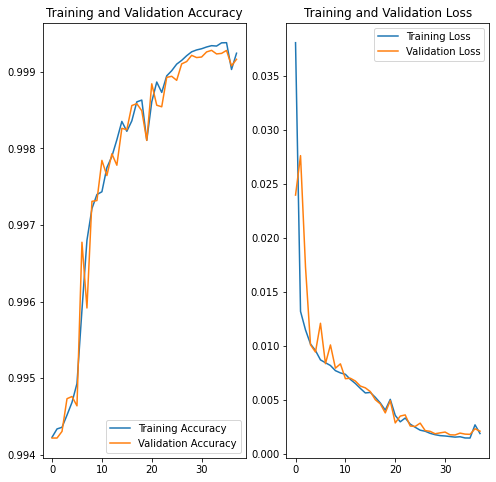

In [63]:
import matplotlib.pyplot as plt
training_loss=results.history['loss']
training_accuracy=results.history['accuracy']
validation_loss=results.history['val_loss']
validation_accuracy=results.history['val_accuracy']
'''
#epochs=range(len(acc))
#plt.plot(epochs,training_accuracy,'r',label='Tranining accuracy')
#plt.plot(epochs,validation_accuracy,'b',label='Validation accuracy')
#plt.title('Tranining and Validation accuracy')
#plt.legend(loc=0)
#plt.figure()
#plt.show()
'''
epochs_range=range(len(training_accuracy))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#to remove
'''
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=1, epochs=30, callbacks=callbacks)
'''

In [ ]:
#to remove
'''
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(x_train)-1)
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
'''

In [64]:
idx = random.randint(0, len(x_train))
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 5s 5s/step


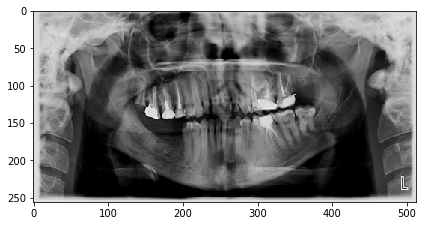

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


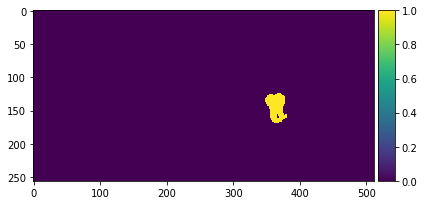

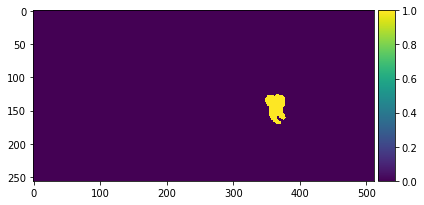

In [124]:
ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

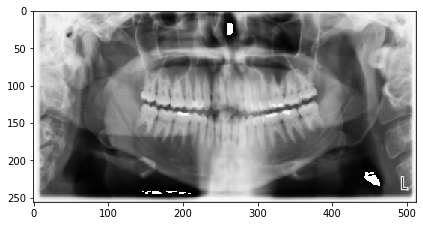

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


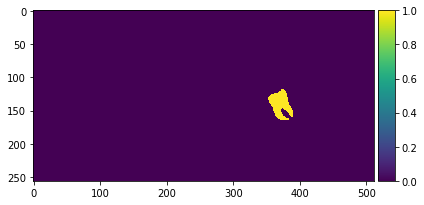

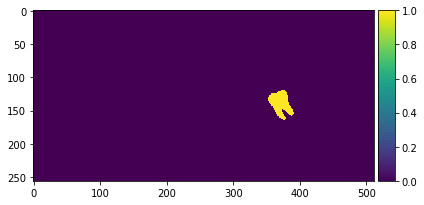

In [99]:
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix]-1)
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

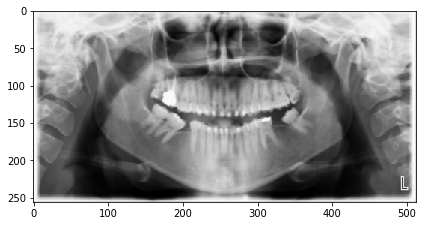

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


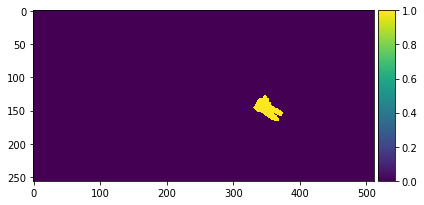

In [76]:
#testing with test set
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [ ]:
#load saved model
model = tf.keras.models.load_model('/content/model5.h5', custom_objects={'KerasLayer': hub.KerasLayer})
model.summary()

In [ ]:
#to remove
'''
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

idx = -1#random.randint(0, len(x_train)-1)
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()
'''

In [ ]:
#test U-net useful ref https://pallawi-ds.medium.com/semantic-segmentation-with-u-net-train-and-test-on-your-custom-data-in-keras-39e4f972ec89

#Evaluation 
not implemented yet!

In [ ]:
#https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
#1. Intersection-Over-Union (IoU, Jaccard Index)
from keras import backend as K
def iou_coef(preds_train, preds_test, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


In [ ]:
#2. Dice Coefficient (F1 Score)
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [ ]:
#https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388
def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Ref:


*   https://stackoverflow.com/questions/10989005/do-i-understand-os-walk-right

*   https://www.youtube.com/watch?v=68HR_eyzk00&t=938s 
*   https://www.youtube.com/watch?v=RaswBvMnFxk


*   https://github.com/bnsreenu/python_for_microscopists/blob/master/074-Defining%20U-net%20in%20Python%20using%20Keras.py
* https://www.youtube.com/watch?v=kaE7jQqIFI8
* intresting paper: https://arxiv.org/pdf/2101.08418.pdf




